In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim
from torch.utils.data import random_split, DataLoader

from torchvision import datasets, transforms

import matplotlib.pyplot as plt 

##### Parametrs

In [2]:
DATA_DIR = 'C:/etc/ai/assignment_v2/cell_images'  
BATCH_SIZE = 32
LEARNING_RATE = 0.001
IMG_SIZE = 128  
TRAIN_SPLIT = 0.8  # 80% for training
VAL_SPLIT = 0.1
EPOCHS = 50

##### GPU

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


##### Transform

In [4]:
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8,1.0), ratio=(0.9,1.1)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

##### Dataset loading & Spitting into train/val/test


In [5]:
dataset = datasets.ImageFolder(root=DATA_DIR, transform=train_transform)

In [6]:
total_size = len(dataset)

train_size = int(TRAIN_SPLIT * total_size)
remaining = total_size - train_size

val_size = int(VAL_SPLIT * total_size)
test_size = total_size - train_size - val_size

train_ds, val_ds, test_ds = random_split(
    dataset, [train_size, val_size, test_size]
)

val_ds.dataset.transform  = test_transform
test_ds.dataset.transform = test_transform

print(f"Classes: {dataset.classes} \nSizes — train: {len(train_ds)}, val: {len(val_ds)}, test: {len(test_ds)}")


train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)


Classes: ['Parasitized', 'Uninfected'] 
Sizes — train: 22046, val: 2755, test: 2757


In [ ]:
class NeuralNet(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3,32,5) # (128 - 5 ) * 3
        self.bn1 = nn.BatchNorm2d(32)
        self.pool =  nn.MaxPool2d(3, 3)
        
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.bn2 = nn.BatchNorm2d(64)
        
        ''' из-за оверфиттинга минусуем слой '''
        # self.conv3 = nn.Conv2d(64, 128, 5)
        # self.bn3 = nn.BatchNorm2d(128)
        
        self.dropout = nn.Dropout(p=0.5)
        
        self.fc1 = nn.Linear(64 * 12 * 12, 120)  # 64 instead of 128, also changing 2 to 12. 
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)
        
    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        # x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = torch.flatten(x, 1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

In [8]:
net = NeuralNet().to(device)
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(
    net.parameters(), 
    lr=LEARNING_RATE, 
    momentum=0.9,
    weight_decay=1e-4
)

scheduler = optim.lr_scheduler.StepLR(
    optimizer,
    step_size=20,
    gamma= 0.5
)

##### Necessary for visualization

In [14]:
# must be placed before training
train_losses = []
val_losses   = []
val_accuracies = []

##### Training & Validation

In [15]:
import copy 
best_acc = 0.0
best_model_wts = copy.deepcopy(net.state_dict())

In [16]:
for epoch in range(1, EPOCHS+1):
    net.train()
    train_loss = 0.0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        loss = criterion(net(inputs), labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    
    # validation
    net.eval()
    val_loss = 0.0
    correct  = 0
    total    = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            val_loss += criterion(outputs, labels).item()
            preds = outputs.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    val_loss /= len(val_loader)
    val_acc   = correct / total


    # step of LR Scheduler
    scheduler.step()
    
    print(f"Epoch {epoch:02d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | LR: {scheduler.get_last_lr()[0]:.4e}")
    
    if val_acc > best_acc:
        best_acc = val_acc
        best_model_wts = copy.deepcopy(net.state_dict())
        print(f"  ✨ New best val acc: {best_acc:.4f} — ModelCheckpoint")
    
    # at the end of each epoch
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
 
net.load_state_dict(best_model_wts)

Epoch 01 | Train Loss: 0.1876 | Val Loss: 0.1606 | Val Acc: 0.9521 | LR: 1.0000e-03
  ✨ New best val acc: 0.9521 — ModelCheckpoint
Epoch 02 | Train Loss: 0.1709 | Val Loss: 0.1564 | Val Acc: 0.9539 | LR: 1.0000e-03
  ✨ New best val acc: 0.9539 — ModelCheckpoint
Epoch 03 | Train Loss: 0.1623 | Val Loss: 0.1868 | Val Acc: 0.9296 | LR: 1.0000e-03
Epoch 04 | Train Loss: 0.1542 | Val Loss: 0.1580 | Val Acc: 0.9550 | LR: 1.0000e-03
  ✨ New best val acc: 0.9550 — ModelCheckpoint
Epoch 05 | Train Loss: 0.1432 | Val Loss: 0.1516 | Val Acc: 0.9525 | LR: 1.0000e-03
Epoch 06 | Train Loss: 0.1421 | Val Loss: 0.1399 | Val Acc: 0.9532 | LR: 1.0000e-03
Epoch 07 | Train Loss: 0.1352 | Val Loss: 0.1520 | Val Acc: 0.9510 | LR: 1.0000e-03
Epoch 08 | Train Loss: 0.1296 | Val Loss: 0.1502 | Val Acc: 0.9535 | LR: 1.0000e-03
Epoch 09 | Train Loss: 0.1265 | Val Loss: 0.1482 | Val Acc: 0.9554 | LR: 1.0000e-03
  ✨ New best val acc: 0.9554 — ModelCheckpoint
Epoch 10 | Train Loss: 0.1253 | Val Loss: 0.1465 | Val A

<All keys matched successfully>

##### Visualization of Train_Loss / Val_Loss / Val_Acc

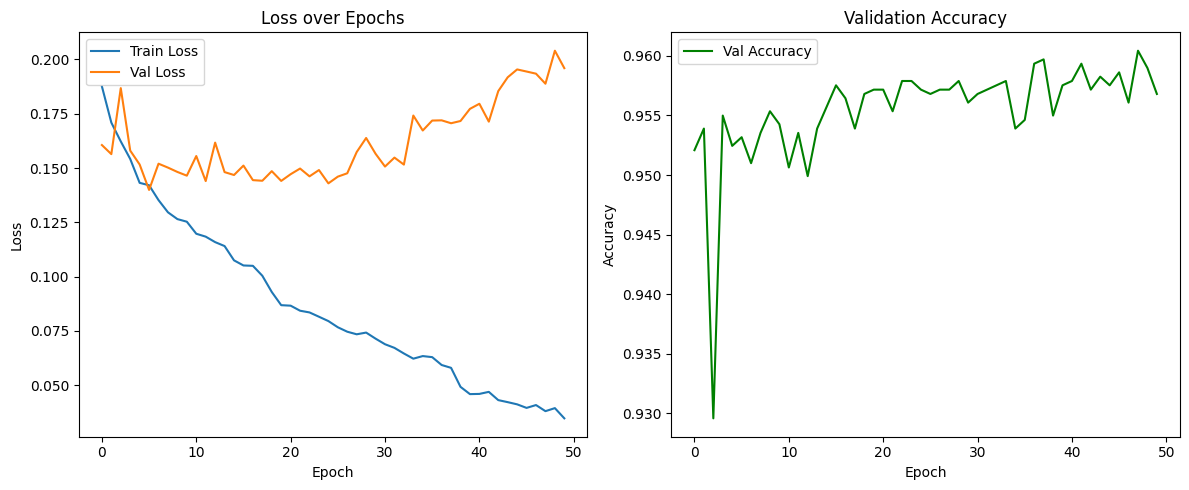

In [20]:
plt.figure(figsize=(12,5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Val Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig('./metrics/loss_acc_val_eval_v2.png')
plt.show()


##### Testing

In [21]:
net.eval()
correct = 0
total   = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        preds = net(inputs).argmax(1)
        correct += (preds == labels).sum().item()
        total   += labels.size(0)
print(f"Test Accuracy: {correct/total:.4f}")

Test Accuracy: 0.9601


#### Saving our model

In [22]:
torch.save(net.state_dict(), 'best_trained_net_v2.pth')

##### Loading the best model

In [ ]:
# execute the NeuralNet cell before loading
net = NeuralNet()
net.load_state_dict(torch.load('best_trained_net.pth'))

<All keys matched successfully>